In [31]:
!pip install classiq
import classiq

# Ensure you are authenticated before proceeding
classiq.authenticate()

/usr/local/lib/python3.10/dist-packages/classiq/_internals/authentication/token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


# Quantum Walk on a Line with 16 Nodes

This notebook explains the algorithm for performing a quantum walk on a line with 16 nodes. We will use the Classiq platform to  synthesize this quantum walk. The process involves preparing the quantum states, setting up the probability distributions, and implementing the necessary quantum gates and operations.

##System Size

We set the size to 4 to represent 16 nodes because $$2^4 = 16$$ This means we need 4 qubits to represent all the nodes in the line.

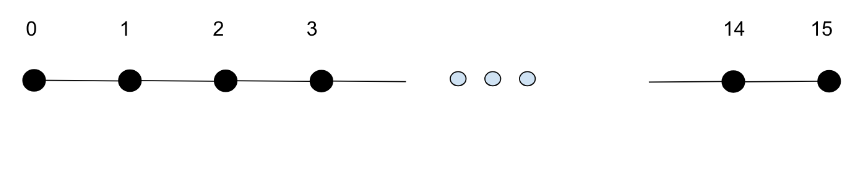

*Image credit: Womanium Quantum + AI Scholarip Program with Classiq on Canva*

In [32]:
# Import the necessary library
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences
# Define the size of the system
size = 4

## State Preparation

The `prepare_minus` function prepares the qubit in the |-⟩ state using X and H gates. The `diffuser_oracle` and `zero_diffuser` functions define the diffuser oracle and apply it conditionally to the quantum state.

In [40]:
# Prepare Minus State
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

# Diffuser Oracle
@qfunc
def diffuser_oracle(aux: Output[QNum], x: QNum):
    aux^=(x != 0)

# Zero Diffuser
@qfunc
def zero_diffuser(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuser_oracle)

## W Iteration

For each state (node) `i`, we set up a probability distribution to move left or right. If `i` is greater than 0, it can move left; if `i` is less than 15, it can move right. The probabilities for moving left or right are both set to 0.5.

The `W_operator` function iterates over all possible states (0 to 15) and applies the `W_iteration` to set up the probability distribution for adjacent vertices.

In [41]:
def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0] * 16
    if i == 0:
        # When at the first node, can only move to the right
        prob[i + 1] = 1.0
    elif i == 15:
        # When at the last node, can only move to the left
        prob[i - 1] = 1.0
    else:
        # For all other nodes, split probability equally between left and right
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5

    print(f'State={i}, prob vec={prob}')

    control(ctrl=vertices == i,
            operand=lambda: within_apply(
                compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action=lambda: zero_diffuser(adjacent_vertices)))

In [42]:
# W Operator
@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2 ** size):
        W_iteration(i, vertices, adjacent_vertices)

## Edge Oracle and Swap Operations

The `edge_oracle` function checks if there is an edge between the current vertex and an adjacent vertex. The `bitwise_swap` function swaps the states between the vertex and the adjacent vertex if there is an edge. The `S_operator` function uses the `edge_oracle` to control the swap operation based on adjacency.

In [36]:
# Edge Oracle
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= ((vertices + adjacent_vertices) % 2 == 1)

# Bitwise Swap
@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

# S Operator
@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

## Main Function

The `main` function allocates qubits for vertices and adjacent vertices. It applies the Hadamard transform to create a superposition of all possible vertex states. Then it applies the `W_operator` to evolve the walk and the `S_operator` to swap vertices based on adjacency.

In [43]:
# Main Function
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

## Create the Quantum Model

The final block of code creates the quantum model, synthesizes the quantum program, and displays the synthesized quantum circuit.

In [44]:
# Create the quantum model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec=[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec=[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec=[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec=[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec=[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec=[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec=[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec=[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec=[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Stat

some circuit images are added to show the operations. The whole circuit can not be added due to large size. However, main operations can be observed from these images.
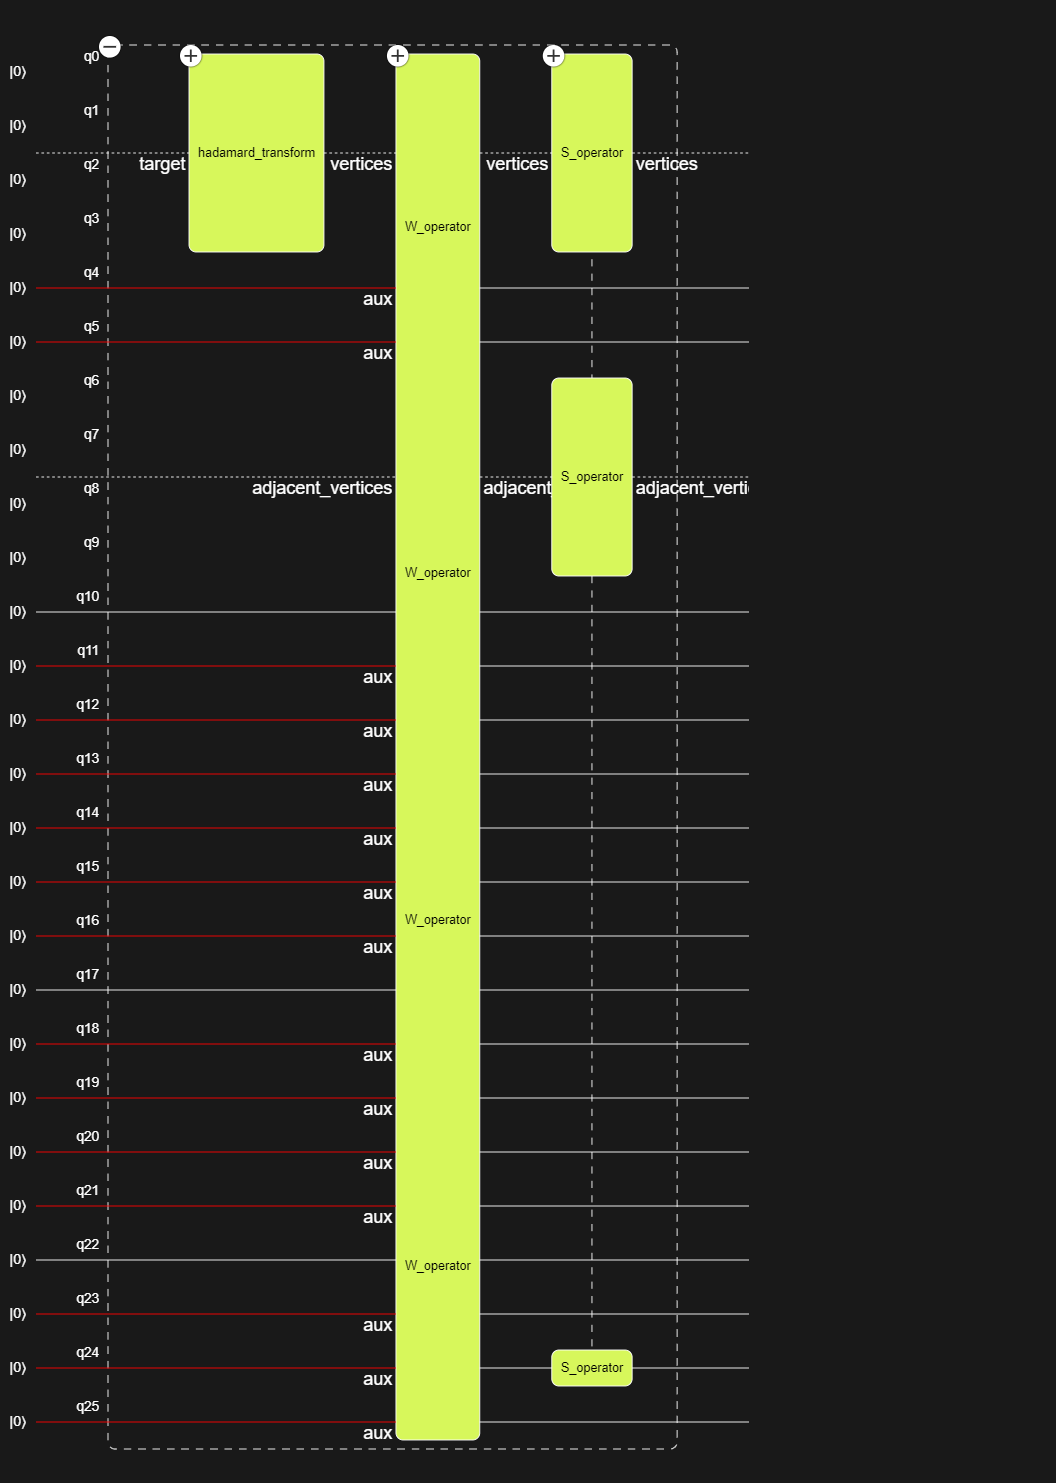

*Image: from classiq platform*

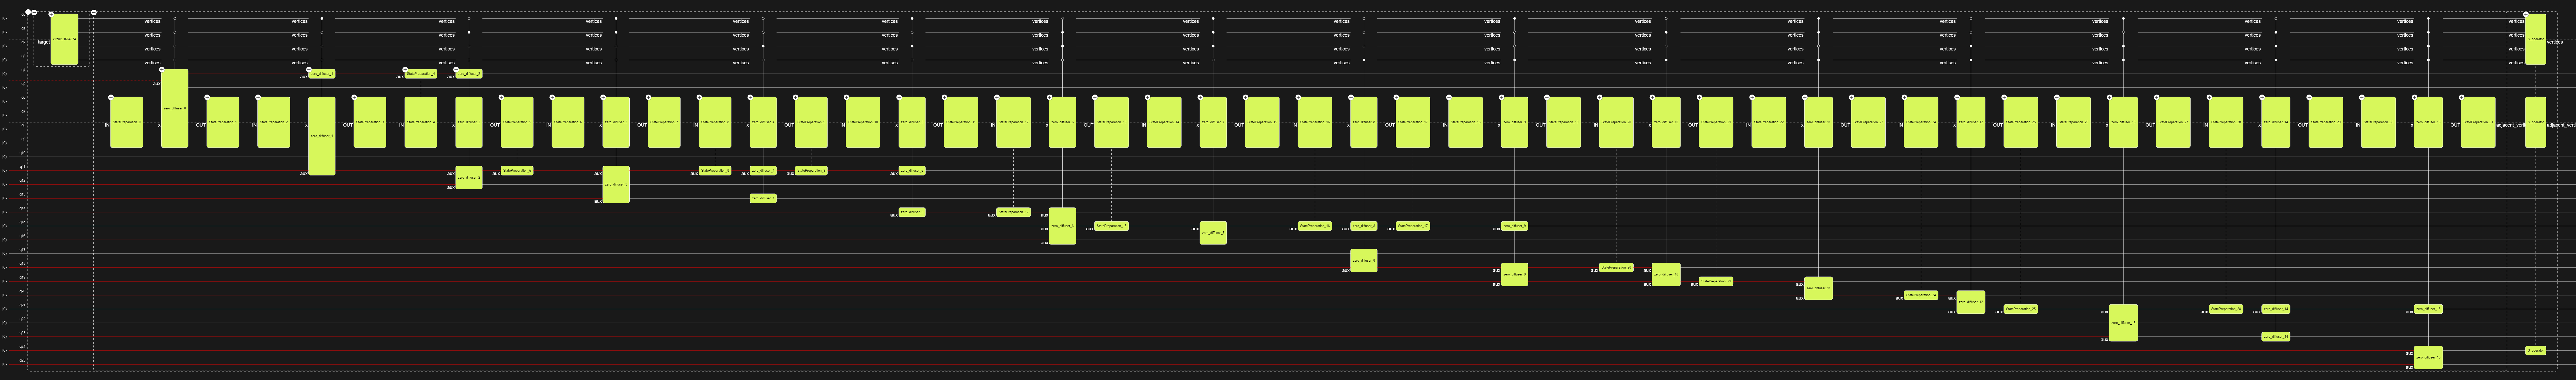




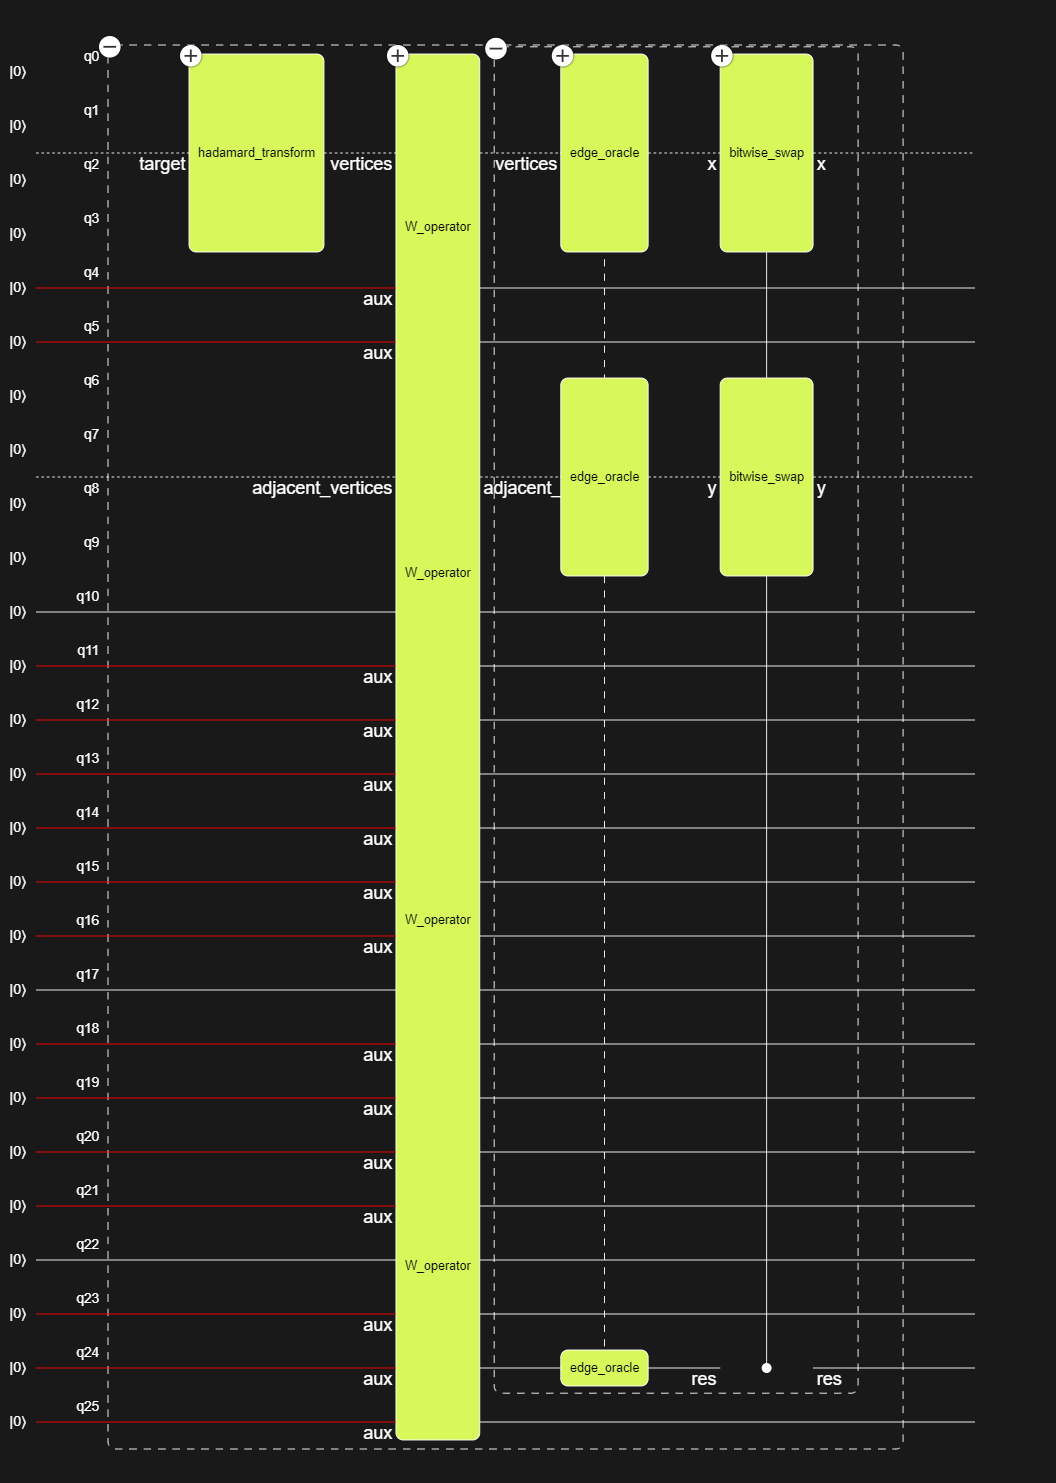